# Загрузка Pandas и очистка данных

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import re 
import numpy as np
import seaborn as sns 


In [2]:
df = pd.read_csv('main_task_new.csv')

In [3]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


Подробнее по признакам:

- City: Город
- Cuisine Style: Кухня
- Ranking: Ранг ресторана относительно других ресторанов в этом городе
- Price Range: Цены в ресторане в 3 категориях
- Number of Reviews: Количество отзывов
- Reviews: 2 последних отзыва и даты этих отзывов
- URL_TA: страница ресторана на 'www.tripadvisor.com'
- ID_TA: ID ресторана в TripAdvisor
- Rating: Рейтинг ресторана

In [5]:
# find if there were any duplicates in the data
print("Дубликатов найдено:", df.duplicated(keep=False).sum())

Дубликатов найдено: 0


In [6]:
# drop the unuseful columns
df.drop(['URL_TA', 'ID_TA'], axis=1, inplace=True)

## Number of Reviews

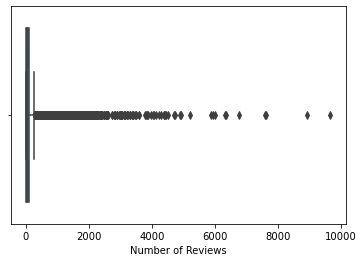

In [7]:
# look at the Number of Reviews outliers
sns.boxplot(df['Number of Reviews'])

In [8]:
# according to the boxplot it seems that values higher than 5000 are real outliers
# fill outlier values with 5000
df['Number of Reviews'] = df['Number of Reviews'].apply(lambda x: 5000 if x>5000 else x)

In [9]:
# fill Nan values with the mean value of Cities
df['Number of Reviews'] = df.groupby("City")['Number of Reviews'].apply(lambda x: x.fillna(round(x.median())))

## Cuisine Style

In [10]:
# add new column with the number of types of Cuisine
df['Cuisine Style'] = df['Cuisine Style'].str.replace("[", "")
df['Cuisine Style'] = df['Cuisine Style'].str.replace("]", "")
df['Cuisine Style'] = df['Cuisine Style'].str.replace("'", "")
df['Cuisine Style'] = df['Cuisine Style'].str.split(', ')
df['Cuisine Count'] = df['Cuisine Style'].apply(
    lambda x: 1 if type(x) == float else len(x))

In [11]:
# determine the most common Cuisine Styles
cuisine = []
for l in df.loc[df['Cuisine Style'].isna()==False]['Cuisine Style']:
    for c in l:
        cuisine.append(c)
        
top_cuisine = list(pd.Series(cuisine).value_counts().index[:5])
top_cuisine

['Vegetarian Friendly',
 'European',
 'Mediterranean',
 'Italian',
 'Vegan Options']

In [12]:
# add dummy variables with the most common Cuisine Styles
# def top_cuisine_dummy(cuisine_list, i):
#    top_cuisine = ['Vegetarian Friendly',
#                   'European',
#                   'Mediterranean',
#                   'Italian',
#                   'Vegan Options']
#    if top_cuisine[i] in cuisine_list:
#        return 1
#    else:
#        return 0


# for i in range(3):
#    df[top_cuisine[i]] = df['Cuisine Style'].apply(
#        lambda x: 0 if type(x) == float else top_cuisine_dummy(x, i))

# leads to worse MAE

In [13]:
df.drop(['Cuisine Style'], axis=1, inplace=True)

## Price Range

In [14]:
# changing denotation of Price Range to int type
# giving a Nan separate category
def to_nominal(price_range):
    if price_range == '$$$$':
        return 3
    elif price_range == '$':
        return 1
    elif price_range == '$$ - $$$':
        return 2
    else: 
        return 0


df['Price Range'] = df['Price Range'].apply(to_nominal)


## Reviews

In [15]:
# add a new column with review _dates in datetime format 
def to_datetime(review):
    pattern = re.compile('\'\d+\/\d+\/\d+\'?')
    date_list = pattern.findall(review)
    if len(date_list) >= 2:
        datetime_list = []
        for date in date_list:
            date = date[1:-1]
            datetime_list.append(datetime.strptime(date, '%m/%d/%Y'))
        return datetime_list
    elif len(date_list) == 1:
        return [datetime.strptime(str(date_list[0]), "'%m/%d/%Y'")]
    else:
        return date_list


df['Reviews'] = df['Reviews'].astype(str)
df['review_dates'] = df['Reviews'].apply(lambda x: to_datetime(x))

In [16]:
# add a new column with day difference between reviews
def time_delta(date_list):
    if len(date_list) == 2:
        return abs((date_list[-1]-date_list[0]).days)
    else:
        return 0


df['review_date_difference'] = df.review_dates.apply(time_delta)

In [17]:
df.drop(['review_dates'], axis=1, inplace=True)

In [18]:
# determinig the positivity of reviews
def review_reader(review):
    good_words = ['excellent', 'nice', 'best', 'lovely', 'amazing',
                  'good', 'perfect', 'gorgeous', 'pleasant', 'delicious', 'great',
                  'friendly', 'pleasant', 'welcoming', 'satisfying', 'tasty', 'yummy',
                  'sweet', 'loved', 'like', 'happy', 'wonderful', 'excellent', 'unique',
                  'yum', 'original', 'favourite', 'welcoming', 'real deal', 'fabulous', 'unforgettable',
                  'divine', 'unmissable', 'recommended', 'fantastic', 'beautiful', 'wow', 'delightful',
                  'coolest', 'fine', 'happiness', 'unbelievable', 'brilliant', 'extraordinary']
    count = 0
    for word in good_words:
        if word in review.lower():
            count += 1
    if count > 0:
        return 1
    else:
        return 0


df['good_review'] = df.Reviews.apply(review_reader)

In [19]:
df.drop(['Reviews'],axis=1, inplace=True)

## City

In [20]:
df['City'].value_counts()

London        5757
Paris         4897
Madrid        3108
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: City, dtype: int64

In [21]:
# add dummy variable capital
capitals = ['London', 'Paris', 'Madrid', 'Berlin', 'Rome',
            'Prague', 'Lisbon', 'Vienna', 'Amsterdam', 'Brussels',
            'Stockholm', 'Budapest', 'Warsaw', 'Dublin',
            'Copenhagen', 'Athens', 'Edinburgh', 'Oslo', 'Helsinki',
            'Bratislava', 'Luxembourg', 'Ljubljana']

df['Capital'] = df['City'].apply(lambda x: 1 if x in capitals else 0)

In [22]:
# add new column with countries 
# label countries nubmerically
countries = {'London': 'UK',
             'Paris': 'France',
             'Madrid': 'Italy',
             'Barcelona': 'Spain',
             'Berlin': 'Germany',
             'Milan': 'Italy',
             'Rome': 'Italy',
             'Prague': 'Czechia',
             'Lisbon': 'Portugal',
             'Vienna': 'Austria',
             'Amsterdam': 'Netherlands',
             'Brussels': 'Belgium',
             'Hamburg': 'Germany',
             'Munich': 'Germany',
             'Lyon': 'France',
             'Stockholm': 'Sweden',
             'Budapest': 'Hungary',
             'Warsaw': 'Poland',
             'Dublin': 'Ireland',
             'Copenhagen': 'Denmark',
             'Athens': 'Greece',
             'Edinburgh': 'Scotland',
             'Zurich': 'Switzerland',
             'Oporto': 'Portugal',
             'Geneva': 'Switzerland',
             'Krakow': 'Poland',
             'Oslo': 'Norway',
             'Helsinki': 'Finland',
             'Bratislava': 'Slovakia',
             'Luxembourg': 'Luxembourg',
             'Ljubljana': 'Slovenia'}

df['Country'] = df['City'].map(countries)
df['Country'] = df['Country'].astype('category')
df['Country'] = df['Country'].cat.codes

In [23]:
# add a column with city population
# calculate number of restaurants per 1000 people ratio in the city
population = {'London': 8825001,
              'Paris': 2148271,
              'Madrid': 3266126,
              'Barcelona': 1620343,
              'Berlin': 3613205,
              'Milan': 1236837,
              'Rome': 2318895,
              'Prague': 1165581,
              'Lisbon': 505526,
              'Vienna': 1691468,
              'Amsterdam': 741636,
              'Brussels': 160553,
              'Hamburg': 1841179,
              'Munich': 1206920,
              'Lyon': 506615,
              'Stockholm': 961609,
              'Budapest': 1741041,
              'Warsaw': 1702139,
              'Dublin': 1024027,
              'Copenhagen': 1153615,
              'Athens': 664046,
              'Edinburgh': 464990,
              'Zurich': 341730,
              'Oporto': 249633,
              'Geneva': 183981,
              'Krakow': 766683,
              'Oslo': 580000,
              'Helsinki': 558457,
              'Bratislava': 423737,
              'Luxembourg': 615729,
              'Ljubljana': 284355}

df['population'] = df['City'].map(population)
df['rest_count'] = df['City'].map(df.City.value_counts().to_dict())
df['rest_per_people'] = df['rest_count']/(df['population']/1000)
df.drop(['rest_count', 'population'], axis=1, inplace=True)

In [24]:
# label cities numerically
# df['City'] = df['City'].astype('category')
# df['City'] = df['City'].cat.codes
# leads to worse MAE

df = pd.get_dummies(df, columns=['City'])

## Restaraunt_id

In [25]:
# df.Restaurant_id = df.Restaurant_id.astype('category')
# df.Restaurant_id = df.Restaurant_id.cat.codes
# leads to worse MAE

In [26]:
df.drop(['Restaurant_id'], axis=1, inplace=True)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [27]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['Rating'], axis = 1)
y = df['Rating']

In [28]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [29]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [30]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [31]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [32]:
y_pred = (y_pred * 2).round()/2

In [33]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1868
